# Titanic Data Clean Up

This is the first notebook in my _Titanic Notebooks_ series. Source code is available from [Gitlab](https://gitlab.com/pirivan/dataware/tree/master/pydata/titanic).

Kernels in the series are:

* [Titanic Data Clean Up](https://nbviewer.jupyter.org/urls/gitlab.com/pirivan/dataware/raw/master/pydata/titanic/titanic-1.ipynb)
* [Titanic Data Exploration](https://nbviewer.jupyter.org/urls/gitlab.com/pirivan/dataware/raw/master/pydata/titanic/titanic-2.ipynb)
* [Titanic Machine Learning Models](https://nbviewer.jupyter.org/urls/gitlab.com/pirivan/dataware/raw/master/pydata/titanic/titanic-3.ipynb)

This kernel creates clean train and test data sets, as follows:

1. Drops useless columns.
1. Encodes categorical features using ordinal numbers so that their values can be used in some of the calculations. The kernel keeps the original columns to facilitate data visualization.
1. Replaces all NaN values with suitable alternatives.

The kernel performs the data analysis on the training dataset exclusively, and then updates the _combined_ dataset, the concatenation of the train and test datasets, as required. Finally the kernel reconstructs and saves the two original datasets in their cleaned up forms.

## Table of Contents
* [The Data Sets](#the-data-sets)
* [The Combined Dataset](#the-combined-dataset)
* [Encoding the Sex Feature](#encoding-sex)
* [Dealing With The Cabin Number](#dealing-with-the-cabin-number)
* [Fixing the Fare Column](#fixing-the-fare-column)
* [Fixing the Embarked Column](#fixing-the-embarked-column)
* [Fixing the Age Entries](#fixing-the-age-entries)
    * [Family Size](#family-size)
    * [Passenger Titles](#passenger-titles)
    * [The Heat Map](#the-heat-map)
    * [Updating Missing Entries with Median Age Values](#median-age-values)
    * [Turning Age Into Integers](#turning-age-into-integers)
* [Removing the Ticket Column](#removing-the-ticket-column)
* [Saving the Cleaned Up Data](#saving-the-cleaned-up-data)

## <a name="the-data-sets"></a>The Data Sets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

Load the training and test datasets into corresponding DataFrames:

In [2]:
train_df = pd.read_csv('data/train.csv')
test_df  = pd.read_csv('data/test.csv')

In [3]:
train_df.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [4]:
test_df.head()

PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S

In [5]:
train_df.shape, test_df.shape

((891, 12), (418, 11))

The training dataset has the `Survived` column which is absent in the test dataset. A 0 on this column means that the passenger died, and a 1 means that the passenger survived.

These are the data types (see [Competition Data](https://www.kaggle.com/c/titanic/data)):
* **Categorical Nominal**: `Survived`: 0 (No), 1 (Yes); `Sex`: male or female; `Embarked`: Cherbourg (C), Queenstown (Q), Southampton (S)
* **Categorical Ordinal**: `Pclass (Ticket Class)`: First class (1), Second class (2), Third class (3)
* **Numerical Discrete**: `SibSP (Siblings & Spouses)`: 0+; `Parch (Parents & Children)`: 0+
* **Numerical Continuous**: `Age`: 0.0+; `Fare`: 0.0+
* **Labels**: `PassengerId`, `Name`, `Ticket`, `Cabin`

## <a name="the-combined-dataset"></a> The Combined Dataset

For the purpose of cleaning up the data this kernel creates a single DataFrame concatenating the training and test datasets. Let's call this dataframe `combined_df`. But before proceeding, let's want to do the following:

1. Set `PassengerId` as the index for each dataset, as this column easily replaces the default pandas integer index that starts at zero.

2. Drop the `Survived` column from the training dataset so that both datasets share the same column labels. This column will be restored once the data cleaning process is finished.

2. Create a hierarchical index where the first level is _type_, one of 'train' or 'test', and the second level is the current range index which the kernel renames to "id". Hierarchical indexing facilitates the recovery of the original training and test datasets.

In [6]:
train_df.set_index('PassengerId', inplace=True)
test_df.set_index('PassengerId', inplace=True)
combined_df = pd.concat([train_df.drop(['Survived'], axis=1), test_df], \
                        keys=['train', 'test'], names=['type', 'id'])
pd.options.display.max_rows = 10
combined_df

Pclass                                               Name     Sex  \
type  id                                                                        
train 1          3                            Braund, Mr. Owen Harris    male   
      2          1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female   
      3          3                             Heikkinen, Miss. Laina  female   
      4          1       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female   
      5          3                           Allen, Mr. William Henry    male   
...            ...                                                ...     ...   
test  1305       3                                 Spector, Mr. Woolf    male   
      1306       1                       Oliva y Ocana, Dona. Fermina  female   
      1307       3                       Saether, Mr. Simon Sivertsen    male   
      1308       3                                Ware, Mr. Frederick    male   
      1309       3                           Peter, Master. Michael J    male   

             Age  SibSp  Parch              Ticket      Fare Cabin Embarked  
type  id                                                                     
train 1     22.0      1      0           A/5 21171    7.2500   NaN        S  
      2     38.0      1      0            PC 17599   71.2833   C85        C  
      3     26.0      0      0    STON/O2. 3101282    7.9250   NaN        S  
      4     35.0      1      0              113803   53.1000  C123        S  
      5     35.0      0      0              373450    8.0500   NaN        S  
...          ...    ...    ...                 ...       ...   ...      ...  
test  1305   NaN      0      0           A.5. 3236    8.0500   NaN        S  
      1306  39.0      0      0            PC 17758  108.9000  C105        C  
      1307  38.5      0      0  SOTON/O.Q. 3101262    7.2500   NaN        S  
      1308   NaN      0      0              359309    8.0500   NaN        S  
      1309   NaN      1      1                2668   22.3583   NaN        C  

[1309 rows x 10 columns]

In [7]:
combined_df.loc['train']

Pclass                                               Name     Sex   Age  \
id                                                                             
1         3                            Braund, Mr. Owen Harris    male  22.0   
2         1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0   
3         3                             Heikkinen, Miss. Laina  female  26.0   
4         1       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0   
5         3                           Allen, Mr. William Henry    male  35.0   
..      ...                                                ...     ...   ...   
887       2                              Montvila, Rev. Juozas    male  27.0   
888       1                       Graham, Miss. Margaret Edith  female  19.0   
889       3           Johnston, Miss. Catherine Helen "Carrie"  female   NaN   
890       1                              Behr, Mr. Karl Howell    male  26.0   
891       3                                Dooley, Mr. Patrick    male  32.0   

     SibSp  Parch            Ticket     Fare Cabin Embarked  
id                                                           
1        1      0         A/5 21171   7.2500   NaN        S  
2        1      0          PC 17599  71.2833   C85        C  
3        0      0  STON/O2. 3101282   7.9250   NaN        S  
4        1      0            113803  53.1000  C123        S  
5        0      0            373450   8.0500   NaN        S  
..     ...    ...               ...      ...   ...      ...  
887      0      0            211536  13.0000   NaN        S  
888      0      0            112053  30.0000   B42        S  
889      1      2        W./C. 6607  23.4500   NaN        S  
890      0      0            111369  30.0000  C148        C  
891      0      0            370376   7.7500   NaN        Q  

[891 rows x 10 columns]

In [8]:
combined_df.loc['test']

Pclass                                          Name     Sex   Age  \
id                                                                         
892        3                              Kelly, Mr. James    male  34.5   
893        3              Wilkes, Mrs. James (Ellen Needs)  female  47.0   
894        2                     Myles, Mr. Thomas Francis    male  62.0   
895        3                              Wirz, Mr. Albert    male  27.0   
896        3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female  22.0   
...      ...                                           ...     ...   ...   
1305       3                            Spector, Mr. Woolf    male   NaN   
1306       1                  Oliva y Ocana, Dona. Fermina  female  39.0   
1307       3                  Saether, Mr. Simon Sivertsen    male  38.5   
1308       3                           Ware, Mr. Frederick    male   NaN   
1309       3                      Peter, Master. Michael J    male   NaN   

      SibSp  Parch              Ticket      Fare Cabin Embarked  
id                                                               
892       0      0              330911    7.8292   NaN        Q  
893       1      0              363272    7.0000   NaN        S  
894       0      0              240276    9.6875   NaN        Q  
895       0      0              315154    8.6625   NaN        S  
896       1      1             3101298   12.2875   NaN        S  
...     ...    ...                 ...       ...   ...      ...  
1305      0      0           A.5. 3236    8.0500   NaN        S  
1306      0      0            PC 17758  108.9000  C105        C  
1307      0      0  SOTON/O.Q. 3101262    7.2500   NaN        S  
1308      0      0              359309    8.0500   NaN        S  
1309      1      1                2668   22.3583   NaN        C  

[418 rows x 10 columns]

In [9]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1309 entries, (train, 1) to (test, 1309)
Data columns (total 10 columns):
Pclass      1309 non-null int64
Name        1309 non-null object
Sex         1309 non-null object
Age         1046 non-null float64
SibSp       1309 non-null int64
Parch       1309 non-null int64
Ticket      1309 non-null object
Fare        1308 non-null float64
Cabin       295 non-null object
Embarked    1307 non-null object
dtypes: float64(2), int64(3), object(5)
memory usage: 116.5+ KB


let's inspect now the number of missing values in the combined dataset to determine which elements need to be fixed.

In [10]:
combined_df.isnull().sum()

Pclass         0
Name           0
Sex            0
Age          263
SibSp          0
Parch          0
Ticket         0
Fare           1
Cabin       1014
Embarked       2
dtype: int64

`Age`, `Fare`, `Cabin`, and `Embarked` need attention.

## <a name="encoding-sex"></a>Renaming the Sex Column
Let's start by renaming the `Sex` column to `Gender`, just because I can:

In [11]:
combined_df.rename({'Sex': 'Gender'}, axis=1, inplace=True)
combined_df.columns

Index(['Pclass', 'Name', 'Gender', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Cabin', 'Embarked'],
      dtype='object')

## <a name="dealing-with-the-cabin-number"></a> Dealing with the Cabin Number
Let's look at the `Cabin` column in the train set:

In [12]:
combined_df.loc['train'].Cabin.isnull().sum()

687

There are 687 null cabin values in the train dataset, out of 891 examples. That is, over 77% of the cabin values are missing. For this reason, let's drop the `Cabin` column from the dataset.

In [13]:
combined_df.drop('Cabin', axis=1, inplace=True)
combined_df.isnull().sum()

Pclass        0
Name          0
Gender        0
Age         263
SibSp         0
Parch         0
Ticket        0
Fare          1
Embarked      2
dtype: int64

## <a name="fixing-the-fare-column"></a>Fixing the Fare Column
Only one example is missing the fare value.

In [14]:
combined_df.loc[combined_df.Fare.isnull()]

Pclass                Name Gender   Age  SibSp  Parch Ticket  Fare  \
type id                                                                         
test 1044       3  Storey, Mr. Thomas   male  60.5      0      0   3701   NaN   

          Embarked  
type id             
test 1044        S

This is an example in the test dataset. Let's look at the ticket fare distribution of equivalent passengers in the training dataset:

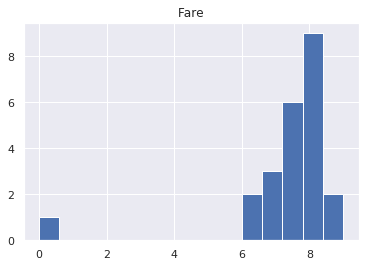

In [15]:
ptype = 'Gender=="male" and Pclass==3 and Embarked=="S"'
alone = 'Parch == 0 and SibSp ==0'
age = 'Age > 40'
fc_df = combined_df.loc['train'].query(ptype).query(alone).query(age)
dist = fc_df.hist(column="Fare", bins=15)

Given the above distribution it is then reasonable to assign to the missing value the median fare of those similar passengers who payed $6 or more.

In [16]:
combined_df.loc[('test', 1044), 'Fare'] = fc_df.query('Fare > 6').Fare.median()
combined_df.isnull().sum()

Pclass        0
Name          0
Gender        0
Age         263
SibSp         0
Parch         0
Ticket        0
Fare          0
Embarked      2
dtype: int64

By the way, there are passengers travelling for free, their recorded fare is zero! Who were they?

In [17]:
pd.options.display.max_rows = 15
free_df = combined_df.loc['train'].query('Fare == 0')
free_df

Pclass                              Name Gender   Age  SibSp  Parch  \
id                                                                         
180       3               Leonard, Mr. Lionel   male  36.0      0      0   
264       1             Harrison, Mr. William   male  40.0      0      0   
272       3      Tornquist, Mr. William Henry   male  25.0      0      0   
278       2       Parkes, Mr. Francis "Frank"   male   NaN      0      0   
303       3   Johnson, Mr. William Cahoone Jr   male  19.0      0      0   
414       2    Cunningham, Mr. Alfred Fleming   male   NaN      0      0   
467       2             Campbell, Mr. William   male   NaN      0      0   
482       2  Frost, Mr. Anthony Wood "Archie"   male   NaN      0      0   
598       3               Johnson, Mr. Alfred   male  49.0      0      0   
634       1     Parr, Mr. William Henry Marsh   male   NaN      0      0   
675       2        Watson, Mr. Ennis Hastings   male   NaN      0      0   
733       2              Knight, Mr. Robert J   male   NaN      0      0   
807       1            Andrews, Mr. Thomas Jr   male  39.0      0      0   
816       1                  Fry, Mr. Richard   male   NaN      0      0   
823       1   Reuchlin, Jonkheer. John George   male  38.0      0      0   

     Ticket  Fare Embarked  
id                          
180    LINE   0.0        S  
264  112059   0.0        S  
272    LINE   0.0        S  
278  239853   0.0        S  
303    LINE   0.0        S  
414  239853   0.0        S  
467  239853   0.0        S  
482  239854   0.0        S  
598    LINE   0.0        S  
634  112052   0.0        S  
675  239856   0.0        S  
733  239855   0.0        S  
807  112050   0.0        S  
816  112058   0.0        S  
823   19972   0.0        S

They were all men travelling alone. They all embarked at port S and were spread almost equally among the three priority classes. A quick Internet search seems to indicate that some (all?) of these men were _American Line_ employees.

## <a name="fixing-the-embarked-column"></a>Fixing the Embarked Column
Only two passengers are missing the `Embarked` value, here they are:

In [18]:
combined_df.loc[combined_df.Embarked.isnull()]

Pclass                                       Name  Gender   Age  \
type  id                                                                     
train 62        1                        Icard, Miss. Amelie  female  38.0   
      830       1  Stone, Mrs. George Nelson (Martha Evelyn)  female  62.0   

           SibSp  Parch  Ticket  Fare Embarked  
type  id                                        
train 62       0      0  113572  80.0      NaN  
      830      0      0  113572  80.0      NaN

These are two examples in the training dataset. Note that the two passengers share the same ticket number. Could it be possible that passengers with the same ticket label embarked at the same port?

In [19]:
def check_port(df):
    return len(df.Embarked.unique()) > 1

df = combined_df.loc['train'].groupby('Ticket').apply(check_port)
df[df].count(), len(df)

(2, 681)

Only in two cases out of 681 is the port of embarkment different for same ticket labels. It is safe then to assume that the two missing port entries should share the same value. But, which port?

First, are there any other passengers with ticket label _113572_ who could provide us with the port of embarkment?

In [20]:
len(combined_df.loc[combined_df.Ticket=='113572'])

2

No, unfortunately only these two passengers share this ticket label.

Second, the two passengers are females with priority class 1. Let's see which embarkment port was used the most by this type of passengers.

In [21]:
combined_df.query('Pclass == 1 and Gender == "female"').groupby('Embarked').count()

Pclass  Name  Gender  Age  SibSp  Parch  Ticket  Fare
Embarked                                                       
C             71    71      71   65     71     71      71    71
Q              2     2       2    2      2      2       2     2
S             69    69      69   64     69     69      69    69

It is mostly a split between the C and S ports. Let's assign then a random port between these two: 

In [22]:
combined_df.loc[('train', [62, 830]), 'Embarked'] = np.random.choice(['C', 'S'])
combined_df.isnull().sum()

Pclass        0
Name          0
Gender        0
Age         263
SibSp         0
Parch         0
Ticket        0
Fare          0
Embarked      0
dtype: int64

## <a name="fixing-the-age-entries"></a>Fixing the Age Entries
There are 263 age entries that need to be fixed by calculating an age estimate. The simplest way to calculate the estimates is to assign the mean age value of the training dataset. But this method  would ignore other additional information we already have, such as the passenger's gender. We could then calculate mean values for males and females, but this would ignore other information as well, such as number of siblings and children. So the question is, which features should we use to estimate the missing age values, and how?

My approach is to calculate a _heat map_ of the features to select the ones more closely correlated with age. I introduce two new features for this purpose:

1. _Family Size_, `Fsize`, calculated as the summ of _Parch_ and _SibSp_ plust one. We'll see how the familiy size compares against its individual components as it relates to contributing to the age estimates.
1. _Title_, `Title`, a feature extracted from the passenger's names with content such as _Mrs_ and _Miss_, which has a built-in connotation of age.

Let's start by calculating the two new features. I then proceed to calculate the heat map, and finally, to calculate and assign the age estimates.

### <a name="family-size"></a>Family Size
The following code creates a new column `Fsize` with the family size calculation described above.

In [23]:
combined_df['Fsize'] = combined_df.Parch + combined_df.SibSp + 1

### <a name="passenger-titles"></a>Passenger Titles
After looking at the `Name` column, it seems that the second word in the name is the title: _Mr_, _Mrs_, _Miss_, and so on. See this random sample as an example:

In [24]:
np.random.seed(3)
idx = np.random.randint(1, len(train_df), 10)
train_df.iloc[idx, 2]

PassengerId
876              Najib, Miss. Adele Kiamie "Jane"
666                            Hickman, Mr. Lewis
251                        Reed, Mr. James George
645                        Baclini, Miss. Eugenie
258                          Cherry, Miss. Gladys
791                      Keane, Mr. Andrew "Andy"
661                 Frauenthal, Dr. Henry William
716    Soholt, Mr. Peter Andreas Lauritz Andersen
877                 Gustafsson, Mr. Alfred Ossian
683                   Olsvigen, Mr. Thor Anderson
Name: Name, dtype: object

This sample has _Miss_, _Mr_, and _Dr_ titles. They all end with a period.

The following code creates a new column `Title` with the string in between the first comma character and a following period in the name.

In [25]:
combined_df['Title'] = combined_df['Name'].str.split(",|\.", expand=True)[1].str.strip()
combined_df.Title.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer', 'Dona'], dtype=object)

There are 18 categories. In addition to the well known English titles, there are the French ones _Mlle_ (Mademoiselle) and _Mme_ (Madame), Spanish/Italian _Don_ and _Dona_ (likely _Doña_ or _Donna_). There are also unexpected categories such as _jonkheer_ and _the Countess_. How many of each?

In [26]:
pd.options.display.max_rows = 20
combined_df.Title.value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Ms                2
Mlle              2
Major             2
Don               1
Capt              1
the Countess      1
Mme               1
Lady              1
Sir               1
Jonkheer          1
Dona              1
Name: Title, dtype: int64

Let's turn the French and Spanish/Italian titles into the common English ones:

In [27]:
combined_df.Title = combined_df.Title.replace(
    {'Mlle': 'Miss',
     'Mme': 'Mrs',
     'Ms': 'Miss',
     'Don': 'Mr',
     'Dona': 'Mrs'
    })
combined_df.Title.value_counts()

Mr              758
Miss            264
Mrs             199
Master           61
Rev               8
Dr                8
Col               4
Major             2
the Countess      1
Capt              1
Lady              1
Sir               1
Jonkheer          1
Name: Title, dtype: int64

The vast majority of titles are the expected English ones. Only one _Sir_ however, did he survive?

In [28]:
idx = combined_df.index[combined_df.Title=='Sir'].tolist()
combined_df.loc[idx]

Pclass                                          Name Gender   Age  \
type  id                                                                       
train 600       1  Duff Gordon, Sir. Cosmo Edmund ("Mr Morgan")   male  49.0   

           SibSp  Parch    Ticket     Fare Embarked  Fsize Title  
type  id                                                          
train 600      1      0  PC 17485  56.9292        C      2   Sir

In [29]:
train_df.loc[600].Survived

1

Yes, he did!

Unfortunately the fact that he survived is of no help because this is the only _Sir_ record in the dataset; there is no way to conclude that "most _Sirs_ survived," for example. The same can be said about all other passenger with a title count of one, and by extension, about all other titles with a low count. For this reason I arbitrary select eight and below as non-relevant counts and collapse the corresponding titles into a single one called _Misc_.

In [30]:
def adjust_title(df):
    if len(df) <= 8:
        df.Title = 'Misc'
    return df

at_df = combined_df.groupby('Title').apply(adjust_title)
combined_df.Title = at_df.Title
combined_df.Title.value_counts()

Mr        758
Miss      264
Mrs       199
Master     61
Misc       27
Name: Title, dtype: int64

By the way, who are those passengers with the _Master_ title?

In [31]:
masters = combined_df.query('Title=="Master"')
masters.Gender.unique(), masters.Age.median(), masters.Pclass.median()

(array(['male'], dtype=object), 4.0, 3.0)

Well, a _master_ is a male child, tipically 4 years old. Good to know! Most _masters_ were class 3 passengers.

### <a name="the-heat-map"></a>The Heat Map
The combined DataFrame has now the family size and title features needed to fix the age entries. I want to calculate the heat map to get an indication of the contribution each attribute has to the survival rate. But before I can draw the heat map I have to turn the `Gender`, `Title` and `Embarked` columns into categories so that they can be included in the heat map.

Let's create the `Gender_cat` column encoding the `Gender` feature in alphabetical order. The mapping is then _female_ $\rightarrow$ 0, _male_ $\rightarrow$ 1.

In [32]:
combined_df['Gender_cat'] = pd.factorize(combined_df.Gender, sort=True)[0]

Let's create the `Embarked_cat` column encoding the port names as ordinals in alphabetical order: C $\rightarrow$ 0, Q $\rightarrow$ 1, S $\rightarrow$ 2.

In [33]:
combined_df['Embarked_cat'] = pd.factorize(combined_df.Embarked, sort=True)[0]

Now, let's assign ordinal numbers to the titles in alphabetical order:_Master_ $\rightarrow$ 0, _Misc_ $\rightarrow$ 1, _Miss_ $\rightarrow$ 2, _Mr_ $\rightarrow$ 3, _Mrs_ $\rightarrow$ 4.

In [34]:
combined_df['Title_cat'] = pd.factorize(combined_df.Title, sort=True)[0]

This is the heat map:

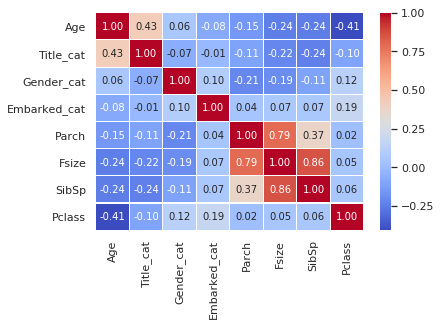

In [35]:
features = ['Age', 'Title_cat', 'Gender_cat', 'Embarked_cat', 'Parch', 'Fsize', 'SibSp', 'Pclass']
ax = sns.heatmap(combined_df[features].corr(), cmap="coolwarm",
                 annot=True, fmt='.2f', linewidths=.05)

The data in the first column tells us that the two biggest contributors to age are title and class. The first one is expected, as it embodies the gender and the seniority of passengers in a single attribute. But the passenger's class comes as a surprise; let's take a closer look:

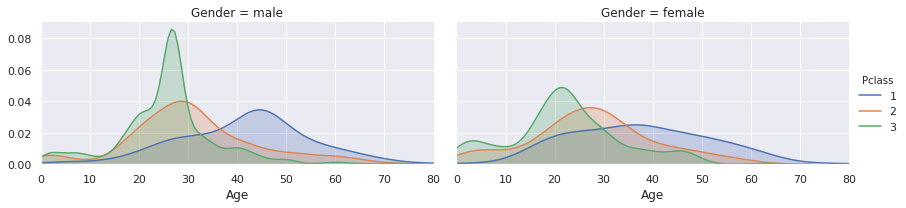

In [49]:
facet = sns.FacetGrid(combined_df, hue='Pclass', col='Gender', height=3, aspect=2)
facet.map(sns.kdeplot, 'Age', shade=True)
facet.set(xlim=(0, train_df.Age.max()))
facet.add_legend()
plt.show()

Indeed, the younger passengers belong to class 3, typically under 30 years old. Passengers of class 2 were somehow older, getting into the 40s and 50s. Passengers of class 1 were the older ones getting into the 60s and over; they were likely the richer ones as well!

The `Embarked` feature doesn't contribute much to age. The `Parch` and `SibSp` contribute more, with the latter being the stronger component. However, `Fsize` seems to capture both of them as its contribution is similar to `SibSp`.

In conclusion, the features of interest as contributors to age estimates are _title_, _priority class_, and _family size_.

### <a name="median-age-values"></a>Updating Missing Entries with Median Age Values
The following code groups passengers in the combined dataset by the selected categories for age estimates, calculates the median age values for passengers in the training dataset, and finally assigns corresponding age values to the missing entries.

In [37]:
def adjust_age(df):
    median = df.query('type == "train"').Age.median()
    return df.fillna(median)

age_df = combined_df.groupby(['Title', 'Pclass', 'Fsize']).apply(adjust_age)
combined_df.Age = age_df.Age
combined_df.isnull().sum()

Pclass           0
Name             0
Gender           0
Age             11
SibSp            0
Parch            0
Ticket           0
Fare             0
Embarked         0
Fsize            0
Title            0
Gender_cat       0
Embarked_cat     0
Title_cat        0
dtype: int64

Wow, there are still 11 passengers missing the age. Who are they? 

In [38]:
combined_df[combined_df.Age.isnull()]

Pclass                               Name  Gender  Age  SibSp  \
type  id                                                                    
train 160        3         Sage, Master. Thomas Henry    male  NaN      8   
      181        3       Sage, Miss. Constance Gladys  female  NaN      8   
      202        3                Sage, Mr. Frederick    male  NaN      8   
      325        3           Sage, Mr. George John Jr    male  NaN      8   
      793        3            Sage, Miss. Stella Anna  female  NaN      8   
      847        3           Sage, Mr. Douglas Bullen    male  NaN      8   
      864        3  Sage, Miss. Dorothy Edith "Dolly"  female  NaN      8   
test  1080       3                    Sage, Miss. Ada  female  NaN      8   
      1231       3              Betros, Master. Seman    male  NaN      0   
      1234       3              Sage, Mr. John George    male  NaN      1   
      1257       3     Sage, Mrs. John (Annie Bullen)  female  NaN      1   

            Parch    Ticket     Fare Embarked  Fsize   Title  Gender_cat  \
type  id                                                                   
train 160       2  CA. 2343  69.5500        S     11  Master           1   
      181       2  CA. 2343  69.5500        S     11    Miss           0   
      202       2  CA. 2343  69.5500        S     11      Mr           1   
      325       2  CA. 2343  69.5500        S     11      Mr           1   
      793       2  CA. 2343  69.5500        S     11    Miss           0   
      847       2  CA. 2343  69.5500        S     11      Mr           1   
      864       2  CA. 2343  69.5500        S     11    Miss           0   
test  1080      2  CA. 2343  69.5500        S     11    Miss           0   
      1231      0      2622   7.2292        C      1  Master           1   
      1234      9  CA. 2343  69.5500        S     11      Mr           1   
      1257      9  CA. 2343  69.5500        S     11     Mrs           0   

            Embarked_cat  Title_cat  
type  id                             
train 160              2          0  
      181              2          2  
      202              2          3  
      325              2          3  
      793              2          2  
      847              2          3  
      864              2          2  
test  1080             2          2  
      1231             0          0  
      1234             2          3  
      1257             2          4

10 of those passengers share the same ticket label _CA. 2343_ and belong to the _Sage_ family of size 11. Because I used `Fsize` for the grouping criteria and none of the entries in this group has an age, this family did not get the age fixed. Let's then remove the family size criteria to fix the age.

In [39]:
age_df = combined_df.groupby(['Title', 'Pclass']).apply(adjust_age)
combined_df.Age = age_df.Age

The final passenger needing an age fix has id 1231 and is part of the test dataset. It is a _Master_ male from class 3, which we know already is a boy 4 years old on average. He has no parents or siblings and is travelling alone! This is very likely the case of an error in the data. I use then the median age of similar passengers to fix this case.

In [40]:
median = combined_df.loc['train'].query('Title == "Master" and Pclass == 3').Age.median()
combined_df.loc[('test', 1231), 'Age'] = median
combined_df.isnull().sum()

Pclass          0
Name            0
Gender          0
Age             0
SibSp           0
Parch           0
Ticket          0
Fare            0
Embarked        0
Fsize           0
Title           0
Gender_cat      0
Embarked_cat    0
Title_cat       0
dtype: int64

All ages are fixed now.

### <a name="turning-age-into-integers"></a>Turning Age Into Integers
While doing the work above to update the missing age entries I noticed that age values are float64 numbers:

In [41]:
combined_df.Age.dtype

dtype('float64')

Why? are there truly fractional age entries, or are they just integer numbers encoded as floats? To find out, let's use the numpy remainder operation, `np.mod`, which is the equivalent of the Python `%` reminder division. Examples using the latter are `3.14 % 1` which returns `.14`, and `3.0 % 1` which returns `0.0`.

In [42]:
age_fractional_entries = combined_df.Age.loc[np.not_equal(np.mod(combined_df.Age, 1), 0)]
age_fractional_entries.values.any()

True

So, yes, there are true fractional age entries.

In [43]:
age_fractional_entries.min(), age_fractional_entries.max()

(0.17, 70.5)

The datasets have age entries ranging from babies less than one year old to people over 70.

There is not much value in having float variables to describe age in this dataset. For example, I don't expect a 30 years old person to be any more or less likely to survive than a 30.6 years old. Let's turn ages into integers rounding up the current values to avoid babies with age 0.

In [44]:
combined_df.Age = np.ceil(combined_df.Age).astype(int)
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1309 entries, (train, 1) to (test, 1309)
Data columns (total 14 columns):
Pclass          1309 non-null int64
Name            1309 non-null object
Gender          1309 non-null object
Age             1309 non-null int64
SibSp           1309 non-null int64
Parch           1309 non-null int64
Ticket          1309 non-null object
Fare            1309 non-null float64
Embarked        1309 non-null object
Fsize           1309 non-null int64
Title           1309 non-null object
Gender_cat      1309 non-null int64
Embarked_cat    1309 non-null int64
Title_cat       1309 non-null int64
dtypes: float64(1), int64(8), object(5)
memory usage: 237.4+ KB


## <a name="removing-the-ticket-column"></a> Removing the Ticket Column

There are 929 unique ticket labels in the combined dataset, which means that there are lots of duplicated values in this column. It would be pointless to attempt to categorize it, I therefore drop it.

In [45]:
combined_df['Ticket'].describe()

count         1309
unique         929
top       CA. 2343
freq            11
Name: Ticket, dtype: object

In [46]:
combined_df.drop(['Ticket'], axis=1, inplace=True)

The ticket column is not really that useless. I explore its connection to family groups in a separate kernel.

## <a name="saving-the-cleaned-up-data"></a>Saving the Cleaned Up Data
The objectives of this notebook are complete: The cabin and ticket columns are there no more, categorical features are encoded with ordinal numbers, and there are no null values in the dataset anymore.

The last step is to save the training and test datasets back to disk in their new cleaned form for the next notebooks in this series to use them. I use the "type" key added earlier in this notebook to split up the combined DataFrame into its training and testing components.

But first, I need to restore the `Survived` column to the training dataset:

In [47]:
pd.options.display.max_rows = 10
train_clean_df = combined_df.loc['train'].copy()
train_clean_df['Survived'] = train_df.Survived
train_clean_df

Pclass                                               Name  Gender  Age  \
id                                                                            
1         3                            Braund, Mr. Owen Harris    male   22   
2         1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female   38   
3         3                             Heikkinen, Miss. Laina  female   26   
4         1       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female   35   
5         3                           Allen, Mr. William Henry    male   35   
..      ...                                                ...     ...  ...   
887       2                              Montvila, Rev. Juozas    male   27   
888       1                       Graham, Miss. Margaret Edith  female   19   
889       3           Johnston, Miss. Catherine Helen "Carrie"  female    1   
890       1                              Behr, Mr. Karl Howell    male   26   
891       3                                Dooley, Mr. Patrick    male   32   

     SibSp  Parch     Fare Embarked  Fsize Title  Gender_cat  Embarked_cat  \
id                                                                           
1        1      0   7.2500        S      2    Mr           1             2   
2        1      0  71.2833        C      2   Mrs           0             0   
3        0      0   7.9250        S      1  Miss           0             2   
4        1      0  53.1000        S      2   Mrs           0             2   
5        0      0   8.0500        S      1    Mr           1             2   
..     ...    ...      ...      ...    ...   ...         ...           ...   
887      0      0  13.0000        S      1  Misc           1             2   
888      0      0  30.0000        S      1  Miss           0             2   
889      1      2  23.4500        S      4  Miss           0             2   
890      0      0  30.0000        C      1    Mr           1             0   
891      0      0   7.7500        Q      1    Mr           1             1   

     Title_cat  Survived  
id                        
1            3         0  
2            4         1  
3            2         1  
4            4         1  
5            3         0  
..         ...       ...  
887          1         0  
888          2         1  
889          2         0  
890          3         1  
891          3         0  

[891 rows x 14 columns]

In [48]:
combined_df.to_csv('data/combined-1.csv')
train_clean_df.to_csv('data/train-1.csv')
combined_df.loc['test'].to_csv('data/test-1.csv')